<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Изучим-эмбеддинги" data-toc-modified-id="Изучим-эмбеддинги-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Изучим эмбеддинги</a></span><ul class="toc-item"><li><span><a href="#Первичный-анализ" data-toc-modified-id="Первичный-анализ-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Первичный анализ</a></span></li><li><span><a href="#Расмотрим-подробно-признаки" data-toc-modified-id="Расмотрим-подробно-признаки-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Расмотрим подробно признаки</a></span></li></ul></li><li><span><a href="#Baseline" data-toc-modified-id="Baseline-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Baseline</a></span><ul class="toc-item"><li><span><a href="#Подготовим-данные" data-toc-modified-id="Подготовим-данные-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Подготовим данные</a></span></li><li><span><a href="#Нормализуем-выборку" data-toc-modified-id="Нормализуем-выборку-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Нормализуем выборку</a></span></li><li><span><a href="#Faiss" data-toc-modified-id="Faiss-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Faiss</a></span></li></ul></li><li><span><a href="#Fast-AI" data-toc-modified-id="Fast-AI-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Fast AI</a></span></li></ul></div>

# Определение жанра по изображению обложки музыкального диска

__Цель__

Необходимо разработать модель, которая определит жанр музыкального альбома по изображению его обложки.

__Данные__

Изображения в формате PNG, упакованные в zip-архивы. Имя архива соответствует музыкальному жанру. Каждый zip-архив содержит папку с изображениями музыкальных обложек соответствующего жанра.

__Метрика__

Метрики для классификации: Accuracy, Precision, Recall, F1.

In [ ]:
# проверим какая среда подключина
!nvidia-smi

Mon Apr 29 19:05:03 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
# установим faiss
! pip install faiss-cpu -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 18.8 MB/s eta 0:00:00


In [ ]:
# установим fastai
! pip install fastai -q

In [ ]:
# импортируем библиотеки
import pandas as pd
import numpy as np
import os
import zipfile
import matplotlib.pyplot as plt
import torch
import faiss
import seaborn as sns

import torch.nn as nn
from torchvision.models import resnet50, ResNet50_Weights
from torchvision import transforms
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from tqdm.notebook import tqdm
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from fastai.vision.all import *


import warnings
warnings.simplefilter('ignore')

In [ ]:
# подключим гугул диск
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# проверяем работу диска
!pwd

/content


In [ ]:
# смотрим на путь к файлам
!ls /content/drive/MyDrive/df

 anime	'black metal'   classical   country   disco   edm   jazz   pop	 rap   reggae


In [ ]:
# константы
SEED = 42                                              # случайные числа
BATCH_SIZE = 32                                        # размер батча
K_NEIGHBORS = 1                                        # количество соседей
IMG_SIDE_RESIZE = 224                                  # длина стороны изображения для ресайза
IMG_SIDE_CROP = 224                                    # длина стороны изображения для кропа
NORMALIZE_MEAN = [0.485, 0.456, 0.406]                 # mean values для нормализации изображений
NORMALIZE_STD = [0.229, 0.224, 0.225]                  # std values для нормализации изображений
PATH_IMAGES = '/content/drive/MyDrive/df'              # путь к основной папке с изображениями
image_vector = '/content/drive/MyDrive/emb.npy'        # путь к эмбеддингам

# Первичный анализ данных

In [ ]:
# Функция загружающаяя картинки из архива.
# На вход принимает полный путь к архиву в формате ziр
# На выходе даёт название жанраи список из картинок в формате PIL.Image
def uzip_and_show(zip):
    imgzip = zipfile.ZipFile(zip)
    inflist = imgzip.infolist()
    flist=[]
    for f in inflist:
        ifile = imgzip.open(f)
        try:
            img = Image.open(ifile)
            flist.append(img)
        except:
            label=os.path.basename(zip)
    return label[:-4],flist

In [ ]:
# жанр anime
anime_labels, anime_df = uzip_and_show('/content/drive/MyDrive/df_zip/anime.zip')

# жанр black_metal
black_metal_labels, black_metal_df = uzip_and_show('/content/drive/MyDrive/df_zip/black metal.zip')

# жанр classical
classical_labels, classical_df = uzip_and_show('/content/drive/MyDrive/df_zip/classical.zip')

# жанр country
country_labels, country_df = uzip_and_show('/content/drive/MyDrive/df_zip/country.zip')

# жанр disco
disco_labels, disco_df = uzip_and_show('/content/drive/MyDrive/df_zip/disco.zip')

# жанр edm
edm_labels, edm_df = uzip_and_show('/content/drive/MyDrive/df_zip/edm.zip')

# жанр jazz
jazz_labels, jazz_df = uzip_and_show('/content/drive/MyDrive/df_zip/jazz.zip')

# жанр pop
pop_labels, pop_df = uzip_and_show('/content/drive/MyDrive/df_zip/pop.zip')

# жанр rap
rap_labels, rap_df = uzip_and_show('/content/drive/MyDrive/df_zip/rap.zip')

# жанр reggae
reggae_labels, reggae_df = uzip_and_show('/content/drive/MyDrive/df_zip/reggae.zip')

In [ ]:
# Функция для просмотра изображени
# На вход подаются название жанра и папка с изображениями
# На выходе 5 изображений каждого жанра
def show_img(target, features):
    fig = plt.figure(figsize=(10,10))
    for i in range(5):
        fig.add_subplot(3, 5, i+1)
        plt.imshow(features[i])
        plt.title(target)
        plt.xticks([])
        plt.yticks([])
        plt.tight_layout()

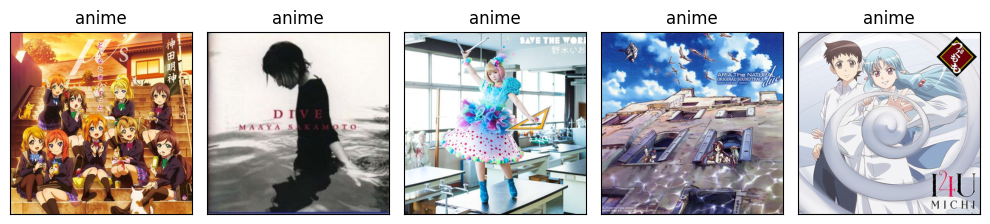

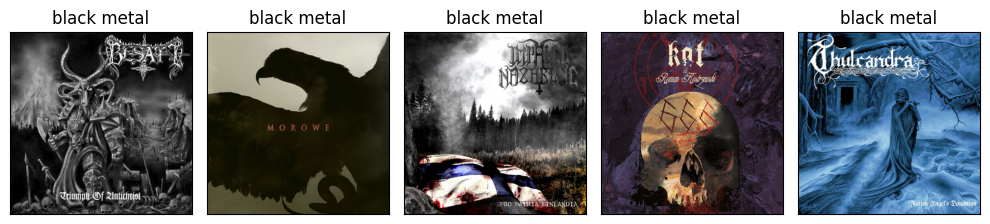

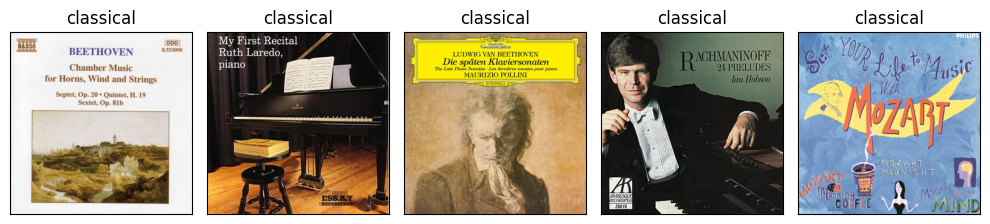

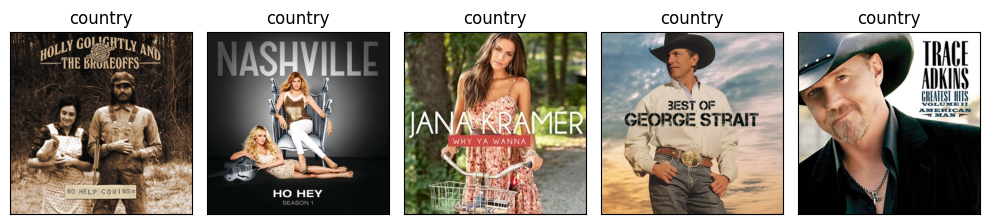

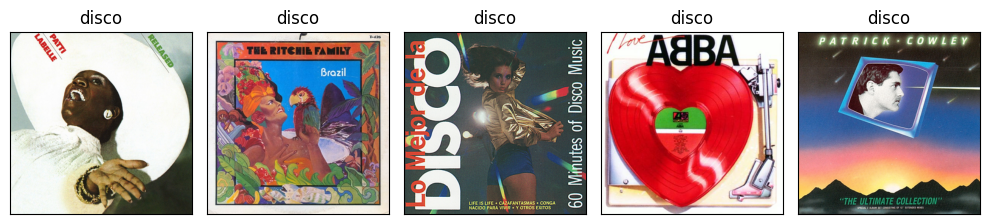

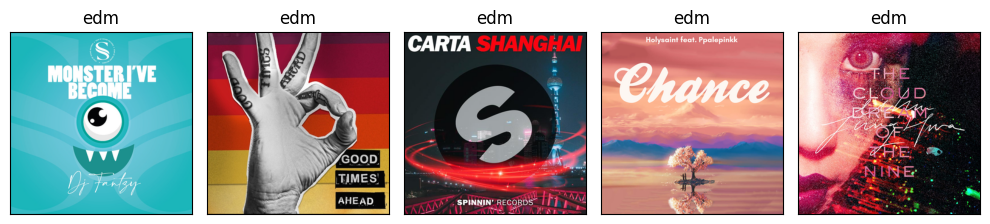

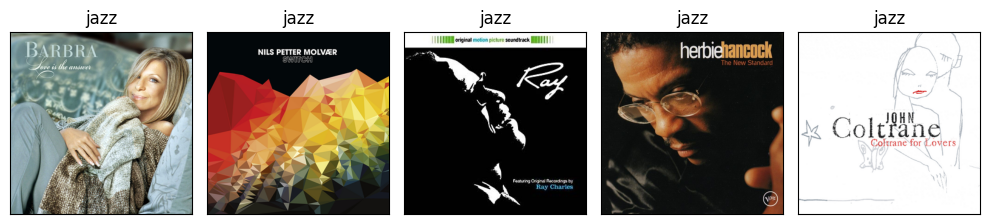

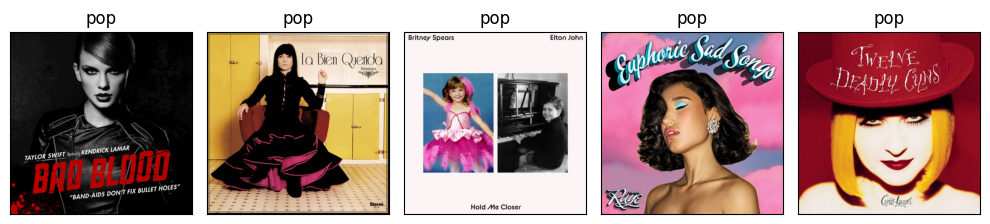

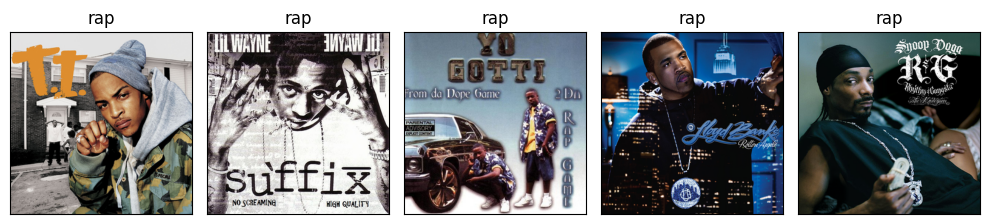

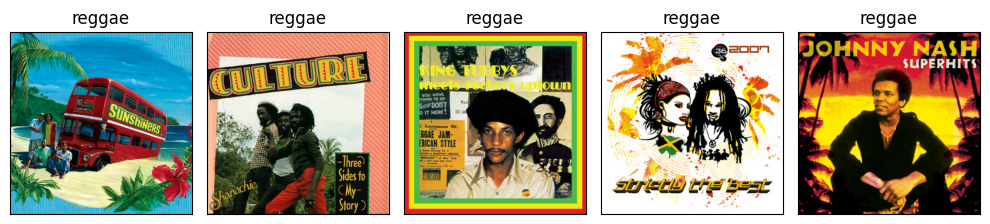

In [ ]:
# изображения
show_img(anime_labels, anime_df)
show_img(black_metal_labels, black_metal_df)
show_img(classical_labels, classical_df)
show_img(country_labels, country_df)
show_img(disco_labels, disco_df)
show_img(edm_labels, edm_df)
show_img(jazz_labels, jazz_df)
show_img(pop_labels, pop_df)
show_img(rap_labels, rap_df)
show_img(reggae_labels, reggae_df)

In [ ]:
# размер файлов
classical_df[1].size

(300, 300)

__Вывод:__

Визуально есть жанры, обожки которых сложно определить. Размер изобдражений 300*300. Всего 10 жанров. Стоит проверить альбомы на мультижанровость, возможно один и тот же альбом класссифифцировался в разные жвнры.

# Получим эмбеддинги

In [ ]:
# создадим датафрейм с жанрами и именами изображений
df = pd.DataFrame(columns=['genre', 'image'])

for root, dirs, files in os.walk(PATH_IMAGES):  # возвращает путь к каталогу, список имен подкаталогов и имен файлов
    genre = root.split('/')[-1]
    data = [{'genre': genre, 'image': os.path.join(genre, file)} for file in files]
    df = pd.concat([df, pd.DataFrame(data)], ignore_index=True)

In [ ]:
print('Размер датафрейма', df.shape)

Размер датафрейма (7800, 2)


In [ ]:
print(df.sample(3)) # проверим как выглядит датафрейм

     genre                                          image
2405   edm   edm/3e416f88-0e02-4d14-b92a-ecf7ebfdfab8.png
2259  jazz  jazz/16e1fb33-1ac9-41fe-9bac-9c6af4304980.png
6696   pop   pop/7c892394-454a-41f2-9f5a-1eb21e0f57e3.png


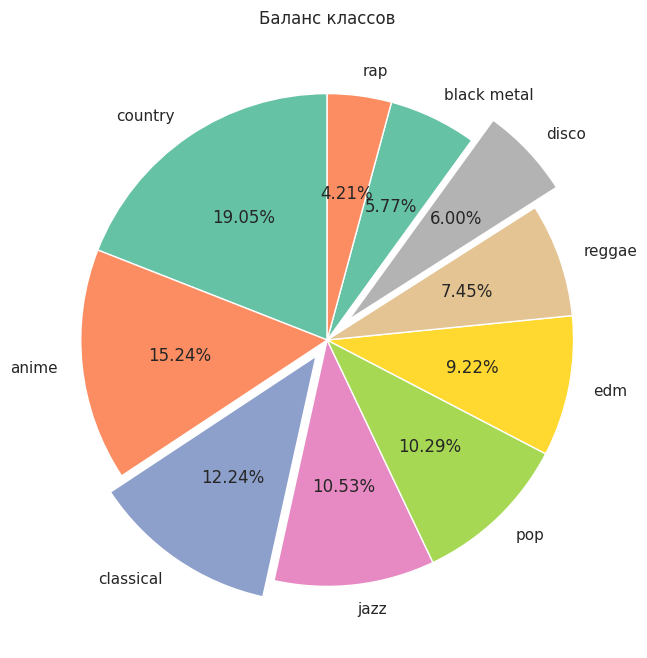

In [ ]:
# граффик баланса классов
genre_counts = df['genre'].value_counts()
labels=genre_counts.index
sns.set(font_scale = 1)
plt.figure(figsize=(8,8))

plt.pie(
    x=genre_counts,
    labels=genre_counts.index,
    autopct='%1.2f%%',
    colors=sns.color_palette('Set2'),
    startangle=90,
    explode=[0, 0, 0.08, 0, 0, 0, 0, 0.12, 0, 0]
)
plt.title('Баланс класcов')
plt.show()

__Вывод:__ Наблюдаем дисбаланс класов. К примеру класса Counrty в четыре раза больше, чем Rap.

In [ ]:
# Конвейер для препроцессинга изображений
preproc = transforms.Compose([
                              transforms.Resize(IMG_SIDE_RESIZE),
                              transforms.CenterCrop(IMG_SIDE_CROP),
                              transforms.ToTensor(),
                              transforms.Normalize(mean=NORMALIZE_MEAN, std=NORMALIZE_STD),
                             ])

In [ ]:
# Модель для векторизации изображений
model_image_vector = resnet50(weights=ResNet50_Weights.DEFAULT)             # предобученная модель resnet50

for param in model_image_vector.parameters():                               # 'заморозка' весов
    param.requires_grad_(False)

layers = list(model_image_vector.children())[:-1]                           # удаление [последнего] слоя для классификации
model_image_vector = nn.Sequential(*layers)                                 # создание модели без слоя для классификации

model_image_vector.eval();

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 153MB/s]


In [ ]:
# Функция для векторизации изображений
def get_image_vector(row, path_image):
    img = Image.open(f'{path_image}/{row.image}').convert('RGB')
    image_tensor = preproc(img)
    output_tensor = model_image_vector(image_tensor.unsqueeze(0)).flatten()
    return output_tensor.numpy()

In [ ]:
#tqdm.pandas()
# Создание массива эмбеддингов
#image_vector = df.apply(get_image_vector, path_image=PATH_IMAGES, axis=1)
#image_vector_array = np.vstack(image_vector)

Для удобства сохраним полученные эмбеддинги, что бы не извлекать их каждый раз.

In [ ]:
image_vector_array = np.load(image_vector)

In [ ]:
print('Размер полученных эмбеддингов', image_vector_array.shape)

Размер полученных эмбеддингов (7800, 2048)


In [ ]:
print('посмотрим первые 20 значений', image_vector_array[0][:20])

посмотрим первые 20 значений [8.2330629e-03 8.0212770e-04 1.2369387e-02 0.0000000e+00 2.8674436e-01
 0.0000000e+00 1.0242923e+00 1.1575320e-03 0.0000000e+00 0.0000000e+00
 0.0000000e+00 5.6417865e-01 0.0000000e+00 1.4393017e-02 5.2586817e-03
 0.0000000e+00 1.7829038e-01 0.0000000e+00 0.0000000e+00 7.5538498e-03]


In [ ]:
# переведем numpy массиэ полученных эмбеддингов в датафрей
emb_data = pd.DataFrame(data=image_vector_array)

In [ ]:
# Посмотрим на веторое представление трех изображений
print(emb_data.sample(3))

      0         1         2         3         4         5        6     \
7061   0.0  0.000000  0.003941  0.054027  0.589604  0.054576  0.00000   
6155   0.0  0.002226  0.129220  0.000000  0.543003  0.149371  0.01109   
4413   0.0  0.000000  0.000000  0.000000  1.496871  0.059947  0.00000   

          7     8     9     ...  2038      2039      2040      2041  2042  \
7061  2.923236   0.0   0.0  ...   0.0  0.000000  0.028374  0.000000   0.0   
6155  1.445201   0.0   0.0  ...   0.0  0.123988  0.000000  0.182517   0.0   
4413  1.185329   0.0   0.0  ...   0.0  0.000000  0.007404  0.460071   0.0   

          2043      2044      2045  2046      2047  
7061  0.000000  0.854142  0.008131   0.0  0.014866  
6155  0.252917  0.002066  0.001380   0.0  0.044552  
4413  0.506435  0.381142  0.484273   0.0  0.035766  

[3 rows x 2048 columns]


## Изучим эмбеддинги

### Первичный анализ

In [ ]:
# сделаем копию датасета
temp_emb_data = emb_data.copy()

In [ ]:
# функция для первичного анализа
def info(data):
    display(data.info())
    display(data.sample(10))
    display(data.describe().T)
    print(data.isna().sum())
    print('Количество дубликатов: ', data.duplicated().sum())
    print('Количество признаков: ', data.shape[1], 'Количество значений: ', data.shape[0])

In [ ]:
info(emb_data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7800 entries, 0 to 7799
Columns: 2048 entries, 0 to 2047
dtypes: float32(2048)
memory usage: 60.9 MB


None

0         1         2         3         4         5         6     \
6084  0.000000  0.000000  0.045887  0.041741  2.177610  0.000000  0.000000   
1699  0.107653  0.063255  0.010429  0.019545  0.507416  0.460554  0.031628   
1522  0.154274  0.000000  0.350950  0.000000  2.153703  0.736353  0.013005   
5310  0.033228  0.000000  0.428826  0.003851  0.473238  0.000000  0.000000   
7597  0.087851  0.000000  0.000000  0.000000  5.001227  0.000000  0.305610   
4766  0.100789  0.000000  0.315132  0.000000  2.058604  0.004813  0.129698   
6874  0.000000  0.000000  0.055698  0.000000  0.005143  0.000000  0.000000   
7504  0.053514  0.016991  0.174961  0.113935  1.780487  0.083988  0.184986   
7761  0.164198  0.008770  0.024430  0.016399  2.572549  0.011404  0.327556   
2399  0.015134  0.000000  0.000000  0.000000  1.672904  0.000000  0.000000   

          7         8         9     ...      2038      2039      2040  \
6084  0.004175  0.586379  0.002360  ...  0.000000  0.158467  0.246346   
1699  0.001803  0.148786  0.016540  ...  1.048524  0.000000  0.017542   
1522  0.119887  0.000000  0.000000  ...  0.000000  0.000000  0.000000   
5310  0.196161  0.000000  0.000000  ...  0.000000  0.319537  0.354788   
7597  0.000000  0.029256  0.000000  ...  0.000000  0.000000  0.004975   
4766  1.789738  0.000000  0.009190  ...  0.116136  0.066018  0.271587   
6874  1.274483  0.000000  0.108498  ...  0.000000  0.211378  0.051938   
7504  0.000000  0.039305  0.231591  ...  0.284455  0.025724  0.000000   
7761  0.000000  0.858185  0.000000  ...  0.000000  0.000000  0.000000   
2399  0.000000  0.022907  0.000000  ...  0.015418  0.099800  0.183305   

          2041      2042      2043      2044      2045      2046      2047  
6084  0.000000  0.000000  0.000000  0.011036  0.012388  0.000000  0.000000  
1699  0.055655  0.055528  0.000000  0.082580  0.083750  0.000000  0.000000  
1522  0.997882  0.000000  0.019014  0.020878  0.056624  0.000000  0.313894  
5310  0.000814  0.000000  0.000000  0.000000  0.000000  0.000000  0.042960  
7597  0.000000  0.000000  0.071522  0.000000  0.000000  0.000000  0.000000  
4766  0.515074  0.000000  0.416088  0.059562  0.038139  0.000000  0.013138  
6874  0.098924  0.000000  0.000000  0.000000  0.000000  0.079130  0.000000  
7504  0.086765  0.000000  0.022683  0.047629  0.185627  0.163719  0.000000  
7761  0.000000  0.000000  0.350247  0.041341  0.000000  0.000000  0.016324  
2399  0.000000  0.000000  1.059840  0.000000  0.000737  0.000000  0.101445  

[10 rows x 2048 columns]

count      mean       std  min       25%       50%       75%       max
0     7800.0  0.066233  0.144571  0.0  0.000000  0.008472  0.070115  2.805491
1     7800.0  0.042414  0.121635  0.0  0.000000  0.000000  0.033768  4.133525
2     7800.0  0.133486  0.243031  0.0  0.000000  0.039586  0.153984  3.387776
3     7800.0  0.063098  0.186768  0.0  0.000000  0.000000  0.030987  3.219333
4     7800.0  1.004602  0.901828  0.0  0.318595  0.769726  1.448047  8.580573
...      ...       ...       ...  ...       ...       ...       ...       ...
2043  7800.0  0.097316  0.197948  0.0  0.000000  0.019703  0.107952  3.021680
2044  7800.0  0.255150  0.457460  0.0  0.000000  0.061565  0.288722  5.516812
2045  7800.0  0.053897  0.138954  0.0  0.000000  0.004418  0.045177  2.507969
2046  7800.0  0.019573  0.087548  0.0  0.000000  0.000000  0.000000  2.428108
2047  7800.0  0.094628  0.197039  0.0  0.000000  0.017819  0.099106  3.611882

[2048 rows x 8 columns]

0       0
1       0
2       0
3       0
4       0
       ..
2043    0
2044    0
2045    0
2046    0
2047    0
Length: 2048, dtype: int64
Количество дубликатов:  52
Количество признаков:  2048 Количество значений:  7800


__Вывод:__

Всего мы имеем 7800 изображений, из них 52 альбома одинаковые. Очень разные значения веторов, необходимо нормализовать данные.

In [ ]:
# уберем дубликуты в данных
emb_data.drop_duplicates(inplace=True)

In [ ]:
# проверим размерность
print('Размер полученного датафрейма', emb_data.shape)

Размер полученного датафрейма (7748, 2048)


In [ ]:
# соединим все в один датафрейм
df_join = emb_data.join(df, how='left')

In [ ]:
info(df_join)

<class 'pandas.core.frame.DataFrame'>
Index: 7748 entries, 0 to 7799
Columns: 2050 entries, 0 to image
dtypes: float32(2048), object(2)
memory usage: 61.0+ MB


None

0         1         2         3         4         5         6  \
5917  0.104830  0.000000  0.328351  0.020301  2.098413  0.000000  0.000000   
5669  0.158295  0.000000  0.082850  0.167503  0.796943  0.000000  0.000000   
7558  0.000000  0.000000  0.016785  0.000000  0.000000  0.000000  0.577301   
2656  0.114086  0.211509  0.039882  0.027903  0.601763  0.000000  0.003351   
5922  0.212751  0.061270  0.378804  0.252539  0.215720  0.006682  0.495715   
6144  0.015289  0.000000  0.106688  0.000000  0.057287  0.000000  0.426698   
5551  0.000000  0.004791  0.000000  0.435632  0.235953  0.000000  0.711487   
6819  0.000000  0.000000  1.214888  0.000000  2.915958  0.393135  0.672794   
7172  0.000000  0.000000  0.000000  0.000000  0.103051  0.000000  0.000000   
1030  0.237131  0.000000  0.000000  0.016661  1.579608  0.026029  0.001336   

             7         8         9  ...      2040      2041      2042  \
5917  1.245410  0.000354  0.002889  ...  0.004958  0.000000  0.000000   
5669  3.274778  0.000000  0.000000  ...  0.071876  0.442744  0.000000   
7558  0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000   
2656  0.076750  0.000000  0.000000  ...  0.056427  0.000000  0.000000   
5922  0.063939  0.007661  0.000000  ...  0.005428  0.440724  0.000000   
6144  0.006942  0.020563  0.000000  ...  0.034756  0.000000  0.006320   
5551  1.106011  0.000000  0.000000  ...  0.020803  0.236279  0.000000   
6819  2.642147  0.462203  0.000000  ...  0.046292  0.151644  0.531051   
7172  0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.001460   
1030  0.000000  0.524371  0.000000  ...  0.000000  0.000000  0.000000   

          2043      2044      2045      2046      2047        genre  \
5917  0.058578  0.470986  0.013665  0.000000  0.112347        anime   
5669  0.009328  0.420952  0.233117  0.000000  0.000000        anime   
7558  0.010089  0.000000  0.000000  0.000000  0.000000  black metal   
2656  0.000000  0.184747  0.331495  0.000000  0.002347          edm   
5922  0.484892  0.037532  0.000000  0.000000  0.095134        anime   
6144  0.077313  0.216944  0.000000  0.000000  0.000000        anime   
5551  0.000000  0.000000  0.000000  0.000000  0.000000        anime   
6819  0.181616  0.247796  0.000000  0.009422  0.000000          pop   
7172  0.123151  0.223718  0.060723  0.000000  0.106076          pop   
1030  0.000000  0.000000  0.000000  0.000000  0.000000    classical   

                                                     image  
5917        anime/cc92b6a5-b45f-4241-83de-1d46eb886322.png  
5669        anime/98f974d7-c29a-418c-969e-e9754e038aaf.png  
7558  black metal/8578eb36-0a8f-4fcc-a9cc-a39d59b51305.png  
2656          edm/0a90d581-7b52-42bb-918f-b229cccb446e.png  
5922        anime/7071cc0f-7c09-440e-aaba-72bbeaea0f45.png  
6144        anime/2dbce677-e27f-37d8-9c45-125e9e79a41c.png  
5551        anime/4aacedf9-aef2-4f7f-83b7-cf1a805475ea.png  
6819          pop/bc15b537-adb7-4971-af1e-6f4825330b97.png  
7172          pop/5c1e0f84-2633-4d26-a0f7-981e8f185bf7.png  
1030    classical/7d34e768-ae05-4f8f-9cef-927e4f33af62.png  

[10 rows x 2050 columns]

count      mean       std  min       25%       50%       75%       max
0     7748.0  0.066118  0.144623  0.0  0.000000  0.008390  0.070015  2.805491
1     7748.0  0.042389  0.121491  0.0  0.000000  0.000000  0.033889  4.133525
2     7748.0  0.133455  0.242975  0.0  0.000000  0.039567  0.154394  3.387776
3     7748.0  0.063297  0.187256  0.0  0.000000  0.000000  0.031087  3.219333
4     7748.0  1.003070  0.900977  0.0  0.318209  0.769408  1.445005  8.580573
...      ...       ...       ...  ...       ...       ...       ...       ...
2043  7748.0  0.097278  0.197860  0.0  0.000000  0.019665  0.107913  3.021680
2044  7748.0  0.255748  0.458205  0.0  0.000000  0.061912  0.289599  5.516812
2045  7748.0  0.054002  0.139218  0.0  0.000000  0.004418  0.045241  2.507969
2046  7748.0  0.019477  0.087131  0.0  0.000000  0.000000  0.000000  2.428108
2047  7748.0  0.094172  0.195209  0.0  0.000000  0.017696  0.098809  3.611882

[2048 rows x 8 columns]

0        0
1        0
2        0
3        0
4        0
        ..
2045     0
2046     0
2047     0
genre    0
image    0
Length: 2050, dtype: int64
Количество дубликатов:  0
Количество признаков:  2050 Количество значений:  7748


Каждому изображению соответствует свое векторное описание.

### Расмотрим подробно признаки

In [ ]:
for col in emb_data.columns:
    print(f'Количество уникальных значений {col}', {emb_data[col].value_counts().count()})

Количество уникальных значений 0 {4587}
Количество уникальных значений 1 {3690}
Количество уникальных значений 2 {5767}
Количество уникальных значений 3 {2878}
Количество уникальных значений 4 {7598}
Количество уникальных значений 5 {3575}
Количество уникальных значений 6 {4878}
Количество уникальных значений 7 {6218}
Количество уникальных значений 8 {4557}
Количество уникальных значений 9 {2514}
Количество уникальных значений 10 {3266}
Количество уникальных значений 11 {3299}
Количество уникальных значений 12 {3287}
Количество уникальных значений 13 {5243}
Количество уникальных значений 14 {4064}
Количество уникальных значений 15 {6921}
Количество уникальных значений 16 {3396}
Количество уникальных значений 17 {2830}
Количество уникальных значений 18 {1328}
Количество уникальных значений 19 {5348}
Количество уникальных значений 20 {2906}
Количество уникальных значений 21 {3967}
Количество уникальных значений 22 {4768}
Количество уникальных значений 23 {3906}
Количество уникальных знач

Можно было бы удалить признаки, в которых мало уникальных значений. Думаю они могут негативно влиять на метрику. Но не знаю уместо ли это делать в эибеддингах для изобрважений. Получается я просто ломаю саму картинку в этлм случае.

## Baseline

### Подготовим данные

In [ ]:
# Перемешаем df
df_shuff = shuffle(df_join, random_state=SEED)

In [ ]:
# разделим выбоку
features = df_shuff.drop(['genre',	'image'], axis=1)
target = df_shuff['genre']

In [ ]:
#features.head(3)

In [ ]:
# разделим выборку на тренировочную и тестовую
X_train, X_val, y_train, y_val = train_test_split(features,\
                                                    target,
                                                    random_state=SEED,
                                                    stratify=target,
                                                    test_size=0.25)

In [ ]:
# сбросим индексы
X_train.reset_index(inplace=True, drop=True)
y_train.reset_index(inplace=True, drop=True)
X_val.reset_index(inplace=True, drop=True)
y_val.reset_index(inplace=True, drop=True)

In [ ]:
# сделаем копию датасетов
temp_X_train = X_train.copy()
temp_y_train = y_train.copy()
temp_X_val = X_val.copy()
temp_y_val = y_val.copy()

In [ ]:
# посмотрим размер датасетов
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(5811, 2048)
(5811,)
(1937, 2048)
(1937,)


### Нормализуем выборку

In [ ]:
# Масштабимруем StandartScaler
scaler = StandardScaler()

In [ ]:
# Обучаем на train и трансформируем
X_train = scaler.fit_transform(X_train)

In [ ]:
# трансформируем val
X_val = scaler.transform(X_val)

### Faiss

In [ ]:
# Функция принимает на вход эмбеддинги изображений vec, и число соседий n
# Возвращает жанр наиболее часто встречающийся среди n обложек альбомов наиболее близких к заданному вектору vec

def find_neighbor(vec, n):
    dimensions = X_train.shape[1]                       # размер пространиства
    index = faiss.IndexFlatL2(dimensions)               # задает индекс
    index.train(np.ascontiguousarray(X_train))          # обучение индекс на base_trans
    index.add(np.ascontiguousarray(X_train))            # добавим векторы в индекс
    D, I = index.search(np.ascontiguousarray(X_val), n) # записываем расстояние до соседий и индексы
    rez = pd.DataFrame(columns=['genre'])
    for idx in I.flatten():
        rez.loc[len(rez.index)] = [y_train.iloc[int(idx)]]
    return rez
    # return D, I

In [ ]:
# запишем предсказания
predictions = find_neighbor(X_train, n=K_NEIGHBORS)

In [ ]:
print(predictions)

          genre
0     classical
1     classical
2          jazz
3         anime
4          jazz
...         ...
1932    country
1933    country
1934    country
1935        pop
1936     reggae

[1937 rows x 1 columns]


In [ ]:
print('F_1_weighted с помощью метода ближайших соседий = ', round(f1_score(y_val, predictions, average='weighted'), 2))

F_1_weighted с помощью метода ближайших соседий =  0.41


__Вывод:__

С помощью модели knn поиска ближайших соседий по эвклидову расстоянию удалосль добиться метрики F_1_weighted = 0.41

## Fast AI

In [ ]:
# создадим загрузчик данных из папки
dls = ImageDataLoaders.from_folder(path=PATH_IMAGES, valid_pct=0.2, bs=64)
dls.valid_ds.items[:3]

[Path('/content/drive/MyDrive/df/black metal/0d049588-c48c-4516-9d7d-8e316a39b1d9.png'),
 Path('/content/drive/MyDrive/df/edm/e91f20ec-9306-4375-a05c-9e0d753692ea.png'),
 Path('/content/drive/MyDrive/df/anime/83154794-6fe9-450b-9bd4-69d081cdb86a.png')]

In [ ]:
# создадим обучкение модели
learn = vision_learner(dls,\
                       models.resnet50,
                       metrics=[accuracy, Precision(average='weighted'), Recall(average='weighted'), F1Score(average='weighted')],
                       loss_func=CrossEntropyLossFlat())

In [ ]:
# запустим обучение на 10 эпохах
learn.fine_tune(10)

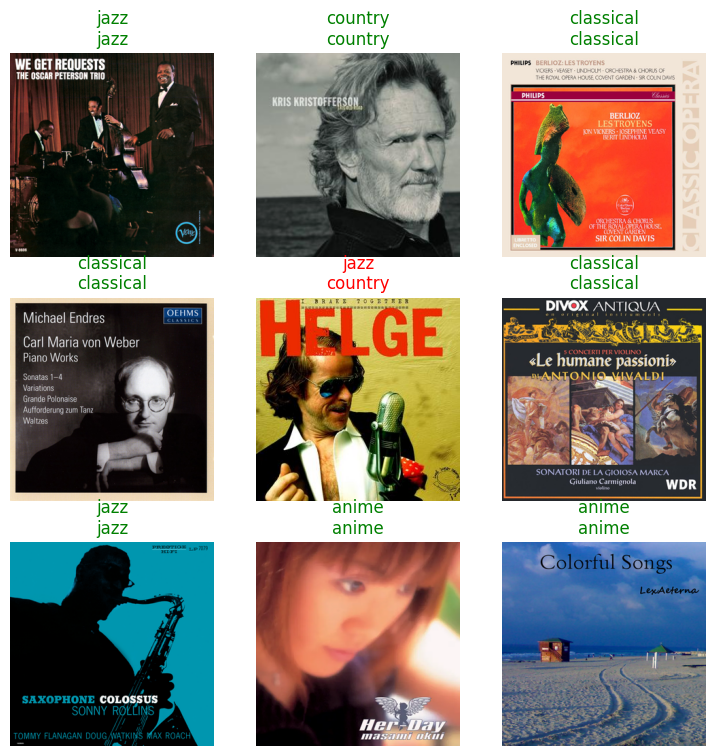

In [ ]:
# посмотрим на каких обложках ошибается или нет наша модель
learn.show_results()

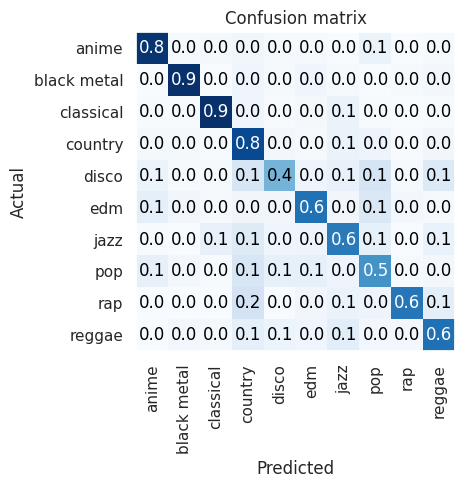

In [ ]:
# матрица ошибок по жанрам
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(normalize=True, norm_dec=1)

__Вывод:__

Использую модель ResNet50 на 10 эпохах удалось добиться следующих метрик: accuracy=0.71, precision_score=0.71, recall_score=0.71, f1_score=0.71. 

__Общий вывод:__

В ходе разработать модель, определит жанр музыкального альбома по изображению его обложки, были изучены обложки 7800 альбомов. Всего предстояла задача разделить имеющиеся изображения альбомов на 10 жанров.

Baseline модель была сделана используя метом KNN расчета эвклидово расстояния. Метрика f1_weighted=0.41, при нахожджении одного ближайшего соседа.

Использую предобученную модель ResNet50 на 10 эпохах удалось добиться следующих метрик: accuracy=0.71, precision_score=0.71, recall_score=0.71, f1_score=0.71. 

Анализ модели показа, что имеются облождки, которые очень хорошо отличимы и легко разделяются по жанрам. В частности обложки жанра anime, black metal, classical и country очень хорошо различимы, модель редко ошибается. Такие жанры как pop, disco, edm различимы значительно хуже. 

Можно порекомендовать для улучшении метрики пересмотреть рассмотрение альбомов по жанрам. К примеру disco и pop можно объединить в один. Так же можно порекомендовать брать так же и обратную сторону для анализа обложки. Выделить текст с обратной стороны и протестировать модель.